<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-study-1.1.1:-Genetic-Codes" data-toc-modified-id="Case-study-1.1.1:-Genetic-Codes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case study 1.1.1: Genetic Codes</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Feature-generation" data-toc-modified-id="Feature-generation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature generation</a></span></li><li><span><a href="#PCA---Visualizing-the-two-principal-components" data-toc-modified-id="PCA---Visualizing-the-two-principal-components-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PCA - Visualizing the two principal components</a></span></li><li><span><a href="#K-Means" data-toc-modified-id="K-Means-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>K-Means</a></span></li><li><span><a href="#Additional-tasks:" data-toc-modified-id="Additional-tasks:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Additional tasks:</a></span></li></ul></div>

# Case study 1.1.1: Genetic Codes

Notebook setup:

In [9]:
import requests
import numpy as np
import itertools
import pandas as pd
import re
import matplotlib.pyplot as plt
from termcolor import colored

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [11]:
### IGNORE THIS CELL ###

#Hiding this cell
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Hide/show</a> cell.''')
display(tag)

### Cell code ### 
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print('List of packages and versions:\n')      
with open(r"requirements.txt", "w") as f:
    for r in requirements:
        print("{}=={}".format(*r))
        f.write("{}=={}".format(*r)+'\n')     
        
### IGNORE THIS CELL ###

List of packages and versions:

scikit-learn==0.22.1
requests==2.23.0
pandas==1.0.0
numpy==1.18.1
matplotlib==3.1.3


# Data 

As it is explained in the guide of Case study 1.1.1, both the genetic sequence of *Caulobacter Crescentus* and the MatLab functions used by the authors, can be download at [link](http://www.ihes.fr/~zinovyev/pcadg/).

With Python's library `requests` we can access the genetic data and transform it in a `string` object:

In [2]:
url = 'http://www.ihes.fr/~zinovyev/pcadg/ccrescentus.fa'
data = ''.join(requests.get(url).text.split('\r\n')[1:])
print('Length of the genetic sequence of Caulobacter Crescentus: {}'.format(len(data)))
print('First 25 characters of the sequence: {}'.format(data[:25]))

Length of the genetic sequence of Caulobacter Crescentus: 305400
First 25 characters of the sequence: gccgatagcctatgatccccggcag


# Feature generation

MatLab function `CalcFreq` generates the features for each 300-characters-long sequence. The next function does the same set of operations:

In [3]:
def CalcFreq(_str,_len,wid):
    '''
    Inputs: 
        _str: complete sequence
        _len: word length (1 to 4 characters)
        wid:  fragments length (in this study: 300 characters)
    Output:
        xx: feature matrix
    '''
    #Cutting sequence into 300 char long pieces
    frags = [_str[i:i+wid] for i in range(0, len(_str), wid)]
    
    #GEnerating possible char combinantions (features)
    chars = ['a','c','g','t']
    features = [''.join(i) for i in list(itertools.product(chars,repeat=_len))]
    
    #Calculating the count of each feature
    xx = np.zeros((len(frags),len(features)))
    for i,frag in enumerate(frags):
        frag = [frag[i:i+_len] for i in range(0, len(frag), _len)]
        for j,feat in enumerate(features):
            xx[i,j] = frag.count(feat)
    
    return xx

In [4]:
xx1 = CalcFreq(data,1,300)
xx2 = CalcFreq(data,2,300)
xx3 = CalcFreq(data,3,300)
xx4 = CalcFreq(data,4,300)

# PCA - Visualizing the two principal components

Once we have obtained the feature matrices, we can reduce their dimensionality by means of PCA. The following functions calculate the two principal components with Python library `sci-kit learn`, and show the results:

In [5]:
def PCAFreq(xx,_len):
    #Standarization of the features
    std_xx = StandardScaler().fit_transform(xx)
    #Dimensionality reduction with PCA
    pca = PCA(n_components=2)
    princ_components = pca.fit_transform(std_xx)
    plot_PCA(princ_components,_len)
    return princ_components

def plot_PCA(princ_components,_len):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.scatter(x=princ_components[:,0],y=princ_components[:,1],
               marker='.',s=3,color='k',
              )
    ax.annotate(s= 'M = {}'.format(_len),xy=[0.1,0.8],xytext = (0.1,0.8),
                xycoords = 'axes fraction',fontsize=14)
    plt.show()
    

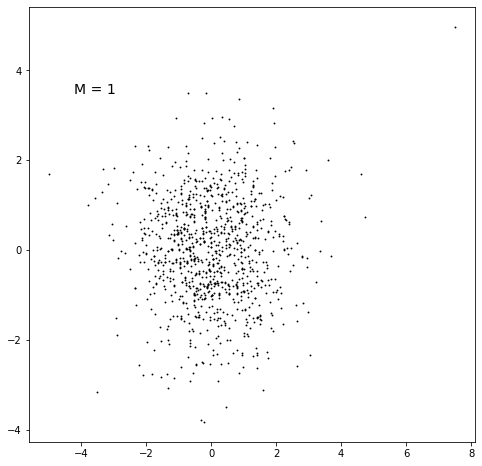

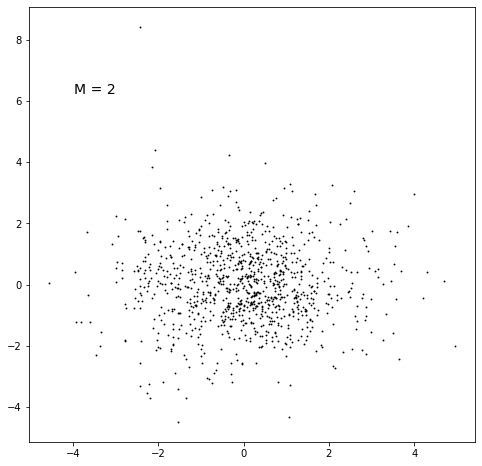

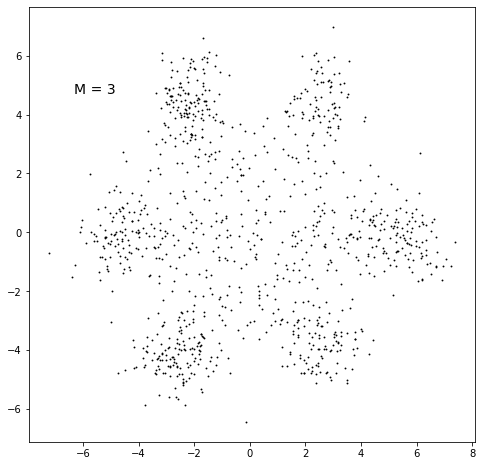

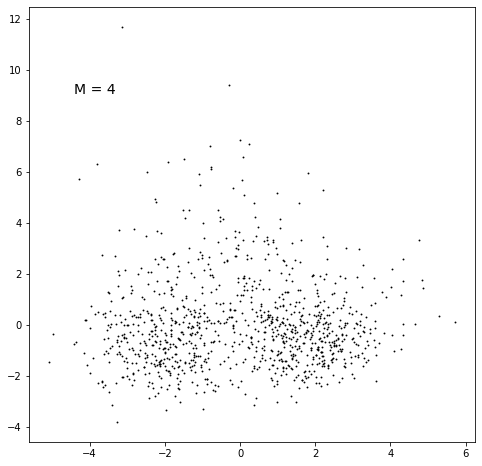

In [6]:
xx1_PCA = PCAFreq(xx1,1)
xx2_PCA = PCAFreq(xx2,2)
xx3_PCA = PCAFreq(xx3,3)
xx4_PCA = PCAFreq(xx4,4)

# K-Means

Finally we can apply K-Means to the matrix generated with 3-characters-long words. Watch out, K-Means is applied to the __64 features__
(not to the two principal components), and then the results can be visualized on top of the PCA analysis, or directly in the genetic sequence.

In [7]:
def ClustFreq(xx,k):
    std_xx = StandardScaler().fit_transform(xx)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(std_xx)
    clusters = kmeans.labels_
    return clusters

def plot_PCA_colors(xx_PCA,clusters):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    black_cluster = (clusters == 4)
    ax.scatter(x=xx_PCA[black_cluster][:,0],y=xx_PCA[black_cluster][:,1],color='k',
               marker='o',s=10)
    ax.scatter(x=xx_PCA[~black_cluster][:,0],y=xx_PCA[~black_cluster][:,1],
               c=clusters[~black_cluster],cmap='Paired_r',marker='o',s=10)
    plt.show()

def plot_letter_with_colors(data,clusters):
    frags = [data[i:i+300] for i in range(0, len(data), 300)]
    color_map = {0:'grey',2:'red',3:'green',4:'yellow',5:'blue',6:'magenta'}
    for i,frag in enumerate(frags):
        if clusters[i] == 1:
            print(frag)
        else:
            print(colored(frag, color=color_map[clusters[i]]))

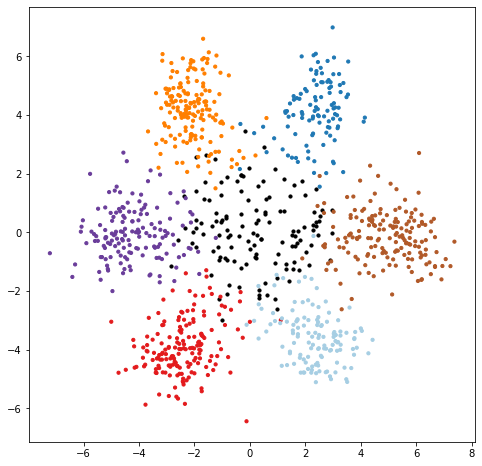

In [8]:
clusters = ClustFreq(xx3,7) 
plot_PCA_colors(xx3_PCA,clusters)

In [1]:
#plot_letter_with_colors(data,clusters)

# Additional tasks:

You can now try to implement the additional suggested tasks explained in the guide of Case study 1.1.1.